# Load in modules

In [1]:
import keras 
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Dense, BatchNormalization, Identity, Input, GlobalAveragePooling2D, \
    RandomSharpness, RandomRotation, RandomFlip, ReLU
from keras.activations import relu
from keras.optimizers import AdamW
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #Tensorflow yaps too much


2025-10-27 13:38:59.902761: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-27 13:38:59.930346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-27 13:39:03.426992: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Load in Data
Here we will load in the data and convert it to a scale of [0, 1]. To reduce the effect of the light spot on the images and increase the contrast between light and dark areas we will use the following function: $img_{new} = (img - 0.2)^{2}$

I0000 00:00:1761568755.287529 2183531 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6152 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


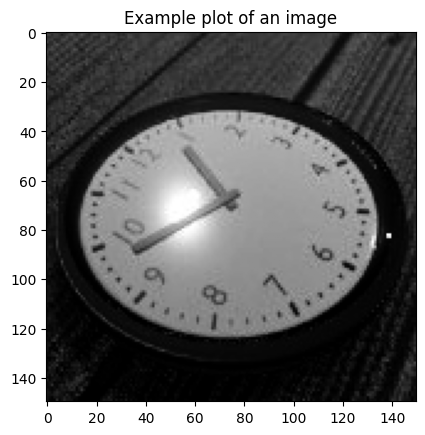

In [2]:
#Converted the image values to a range of [0, 1], better for network to work with
X, y = np.load('data_150/images.npy')/255.0, np.load('data_150/labels.npy')
X_c, y_c = X.copy(), y.copy()
#Simple function to improve the contrast of an img
class ImproveContrast(keras.layers.Layer):
    def __init__(self, alpha=0.2):
        super().__init__()
        self.alpha = alpha
    
    def call(self, x):
        x = (x-self.alpha)**2
        x = tf.where(x < 0, 0.0, x)
        return x
    

plt.title('Example plot of an image')
x = tf.expand_dims(X[1200], axis=-1)
plt.imshow(ImproveContrast().call(x), cmap='grey')

# Classification and Double Head Network

## Load in Data

In [3]:
X = X.astype("float32") / 255.0
X = X[..., np.newaxis]

# Classification CNN

In [4]:
def time_to_label(y, label_range):
    num_classes = 12*60//label_range
    label=(y[:,0]*60 + y[:,1])//label_range
    return label, num_classes

In [ ]:
x = np.expand_dims(X[1200],axis=0)
x = keras.layers.AveragePooling2D(2,2)(x)
x = np.squeeze(x)

plt.imshow(x, cmap="grey")

TypeError: squeeze() got an unexpected keyword argument 'cmap'

In [ ]:
for min_accuracy in [30, 10, 5]:

    y_labels, number_of_classifiers = time_to_label(y, min_accuracy)
    X_traina, X_test, y_traina, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_traina, y_traina, test_size=0.5, random_state=42, shuffle=True)
    
    model_base = keras.Sequential([
        keras.layers.AveragePooling2D(2,2),
        keras.layers.Conv2D(32, (5,5), padding="same", input_shape=X_train[0].shape),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(),

        keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling2D(2,2),

        keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling2D(2,2),

        keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling2D(2,2),

        GlobalAveragePooling2D(),
        Dense(128, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.4),
        Dense(number_of_classifiers, activation="softmax")

        ])

    model_base.compile(
        optimizer=AdamW(learning_rate=5e-4, weight_decay=5e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )


    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6), 
        ModelCheckpoint(f"classifier_{min_accuracy}.keras", save_best_only=True),
        EarlyStopping(patience=10, restore_best_weights=True)
        ]


    history_base = model_base.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=callbacks
    )

    hist_df = pd.DataFrame(history_base.history).to_csv(f'classifier_{min_accuracy}.csv')


## Figures and test performance

In [ ]:
############### Code for figures can be made here ######################

# Multi Headed Network

In [ ]:
def min_to_label(y, label_range):
    num_classes = 60//label_range
    label = y
    label[:,1] //= label_range
    return label, num_classes

In [ ]:
for min_accuracy in [30, 10, 5]:

    y_labels, number_of_classifiers = time_to_label(y, min_accuracy)
    X_traina, X_test, y_traina, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_traina, y_traina, test_size=0.5, random_state=42, shuffle=True)
    model_body = keras.Sequential([
        keras.layers.Conv2D(32, (5,5), padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.MaxPooling2D(),

        keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling2D(2,2),

        keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling2D(2,2),

        keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.AveragePooling2D(2,2),

        keras.layers.GlobalAveragePooling2D(),
        Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4)),
        Dropout(0.4),
        ])

    hours_head=keras.Sequential([
        #layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        #layers.Dropout(0.4),   
        Dense(12, activation="softmax")],name="hours")

    hours_minutes=keras.Sequential([
        #layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        #layers.Dropout(0.4),
        Dense(number_of_classifiers, activation="softmax")],name="minutes")


    input=keras.Input(shape=X[0].shape)
    x=model_body(input)
    out_hours=hours_head(x)
    out_minutes=hours_minutes(x)

    model=keras.Model(inputs=input, outputs=[out_hours,out_minutes])

    model.compile(
        optimizer=AdamW(learning_rate=5e-4, weight_decay=5e-5),
        loss={"hours":"sparse_categorical_crossentropy", "minutes":"sparse_categorical_crossentropy"},
        metrics={
            "hours": ["accuracy"],
            "minutes": ["accuracy"]}
        )

    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6), 
        ModelCheckpoint(f"double_head_{min_accuracy}.keras", save_best_only=True),
        EarlyStopping(patience=15, restore_best_weights=True)
        ]


    history_base = model.fit(
        X_train, [y_train[:,0],y_train[:,1]],
        epochs=100,
        batch_size=64,
        validation_data=(X_val, [y_val[:,0],y_val[:,1]]),
        callbacks=callbacks
    )

    hist_df = pd.DataFrame(history_base.history).to_csv(f'double_head_{min_accuracy}.csv')


## Figures and test performance

In [ ]:
############### Code for figures can be made here ######################

# Label Transformation

In [ ]:
def to_cos_sin(y, label_range):
    label_range=30 #minutes the are togheter in the same class
    number_of_classifiers=12*60//label_range

    hours_decimal=y[:,0]+y[:,1]/60
    hours_normalized=hours_decimal/12
    hours_angolized=hours_normalized*2*np.pi
    labels=np.column_stack((np.cos(hours_angolized), np.sin(hours_angolized)))  
    return labels, number_of_classifiers

def angular_mse(y_true, y_pred):
    # sicurezza: normalizza su cerchio
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    th_t = tf.atan2(y_true[...,1], y_true[...,0])  # atan2(sin, cos)
    th_p = tf.atan2(y_pred[...,1], y_pred[...,0])
    d   = tf.atan2(tf.sin(th_p - th_t), tf.cos(th_p - th_t))  # wrap in (−π, π]
    return tf.reduce_mean(tf.square(d)) 


def angular_mae_minutes(y_true, y_pred):
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    th_t = tf.atan2(y_true[...,1], y_true[...,0])
    th_p = tf.atan2(y_pred[...,1], y_pred[...,0])
    d   = tf.atan2(tf.sin(th_p - th_t), tf.cos(th_p - th_t))
    err_min = tf.abs(d) * (12.*60.) / (2.*np.pi)       # minuti su quadrante 12h
    return tf.reduce_mean(err_min)

class CosSin(keras.layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=-1)
    



In [ ]:

y_labels, number_of_classifiers = to_cos_sin(y, 30)
X_traina, X_test, y_traina, y_test = train_test_split(X, y_labels, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_traina, y_traina, test_size=y_test.shape[0], random_state=42, shuffle=True)

model_base = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), padding="same", input_shape=X_train[0].shape),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),

    keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),    

    keras.layers.GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu" ),
    
    Dropout(0.3),
    keras.layers.Dense(2),
    CosSin()
])

model_base.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=5e-5),
    loss=angular_mse,
    metrics=[angular_mae_minutes]
)

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7), 
    ModelCheckpoint(f"CosSin_model.keras", save_best_only=True),
    EarlyStopping(patience=15, restore_best_weights=True)
    ]

history_base = model_base.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

df = pd.DataFrame(history_base.history).to_csv('CosSin.csv')

## Figures and test performance

In [ ]:
####################### Code for figures #############################

# Regression Network

In [3]:
#Code for Resnet block
class ResBlock(keras.layers.Layer):
    def __init__(self, num_input_layers, num_output_layers, kernel_size):
        super().__init__()
        #For first convolutional layer
        self.conv1 = Conv2D(num_output_layers, kernel_size=kernel_size, padding='same', strides=1, 
                                  kernel_initializer='glorot_uniform')
        self.bn1 = BatchNormalization()
        self.relu = relu

        #For second convolutional layer
        self.conv2 = Conv2D(num_output_layers, kernel_size=kernel_size, padding='same', strides=1, 
                                  kernel_initializer='glorot_uniform')
        self.bn2 = BatchNormalization()

        #If the input and output channels are different, we need to adjust the input
        if num_input_layers != num_output_layers:
            self.shortcut = Conv2D(num_output_layers, kernel_size=1, strides=1, padding='valid')
        else:
            self.shortcut = Identity()
    
    def call(self, x):
        #First convolutional layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        #Second convolutional layer
        x = self.conv2(x)
        x = self.bn2(x)

        #Add shortcut and apply non-linearity
        x += self.shortcut(x)
        x = self.relu(x)

        return x
    
#Code for an Attention block
class AttentionBlock(keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = Conv2D(filters=1, kernel_size=kernel_size, padding = 'same', activation='sigmoid') 
    
    def call(self, x):
        attention = self.conv(x) 
        x *= attention
        return x

In [ ]:
class CNN_regression(keras.Model):
    """Convolutional Neural Network class using residual network blocks"""
    def __init__(self, input_shape=[75, 75, 1], batch_size=64, mode='regression', **kwargs):
        if not isinstance(input_shape, list):
            raise TypeError("input_shape type must be of type 'List'")
         
        if (mode != 'regression') and (mode != 'classification'): #Make shure the mode is always correct
            raise ValueError("The mode of the CNN can either be 'regression' or 'classification'")
        
        if not isinstance(batch_size, int):
            raise TypeError("The batch size must be of type 'int'")

        super().__init__(**kwargs)
        #Just some parameters to keep just in case it is needed later
        self.input_shape = tuple([batch_size] + input_shape)
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.mode = mode

        self.conv_layers = keras.Sequential([
                Input(shape=(self.input_shape)),
                ImproveContrast(0.2),
                
                ResBlock(1, 32, kernel_size=3),
                AttentionBlock(),
                MaxPool2D(pool_size=(2, 2), padding='valid', strides=2),

                ResBlock(32, 64, kernel_size=3),
                AttentionBlock(),
                AvgPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(64, 128, kernel_size=3),
                AttentionBlock(),
                AvgPool2D(pool_size=(2, 2), strides=2, padding='valid'),

                ResBlock(128, 256, kernel_size=3),
                AttentionBlock(),
                GlobalAveragePooling2D(data_format='channels_last')
            
        ])
        
        self.regression_layers = keras.Sequential([
            Input((256,)),
            Dense(300, activation='gelu', kernel_initializer='glorot_normal'),
            Dropout(0.2),
            Dense(150, activation='gelu', kernel_initializer='glorot_normal'),
            Dropout(0.2),
            Dense(1)
        ])


    def call(self, x, training=False):
        x = self.conv_layers(x, training=training)
        if self.mode == 'regression':
            return self.regression_layers(x, training=training)

# Start training for regression

### Split data into train/validation/test set

For regression all the labels will be converted to minutes as unit

In [ ]:
def to_min(x, y):
    y = y[0]*60 + y[1]
    return x, y

with tf.device('/CPU:0'):
    dataset = tf.data.Dataset.from_tensor_slices((X_c, y_c)).map(to_min)
    # Split data into 80/10/10% train/validation/test split
    data_train, data_temp = keras.utils.split_dataset(dataset, 0.8, shuffle=True, seed=42)
    data_valid, data_test = keras.utils.split_dataset(data_temp, 0.5, shuffle=True, seed=42)

    #Convert iterable back to images -> (samples, 75, 75), labels -> (sampels, 2)
    X_train, y_train = next(iter(data_train.batch(len(data_train))))
    X_valid, y_valid = next(iter(data_valid.batch(len(data_valid))))
    X_test, y_test = next(iter(data_test.batch(len(data_test))))


preprocess = keras.Sequential([
        RandomFlip('horizontal_and_vertical'),
        RandomRotation(0.2),
        RandomSharpness((0.7, 0.7), value_range=(0,1)),
    ])

def DataAugment(img, label):
    img = tf.expand_dims(img, axis=-1)
    img = preprocess(img)
    return img, label


2025-10-26 17:46:22.315808: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-26 17:46:23.732925: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Now compile a CNN model and train it on the data

In [6]:
def Loss(y, pred):
    #Loss function for regression. This is also the common sense loss
    pred = tf.math.floormod(pred, 720)
    diff = tf.math.minimum(tf.abs(y - pred), 720 - tf.abs(y - pred))
    return tf.reduce_mean(diff + 1e-8)

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 250

train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(1000)
            .map(DataAugment, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
            )

valid_ds = (tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE)
            )

optim = AdamW(learning_rate=0.0002)
model = CNN_regression(input_shape=[75,75,1], batch_size=BATCH_SIZE, mode='regression')

model.compile(optimizer=optim, loss=Loss)

model_filepath = './task_2/regression_150.model.keras'
callback = [ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7), 
            EarlyStopping(patience=71), 
            ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True, mode='min')]

hist = model.fit(train_ds, validation_data=valid_ds, epochs=NUM_EPOCHS, callbacks=callback)
hist_df = pd.DataFrame(hist.history).to_csv('./task_2/regression_history.csv')
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['loss'])


Epoch 1/250


KeyboardInterrupt: 

In [ ]:
#Summary of model

model = CNN_regression()

model = keras.models.load_model('./task_2/regression_150.model.keras', 
                                custom_objects={'CNN': CNN_regression, 'Loss': Loss})

Model: "cnn_regression_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_17 (Sequential)      │ (None, 256)            │     1,286,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_18 (Sequential)      │ (None, 1)              │       122,401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,223,057 (16.11 MB)

 Trainable params: 1,407,045 (5.37 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 2,814,092 (10.73 MB)

None


Text(0.5, 0.98, 'Training history of the CNN with a regression head')

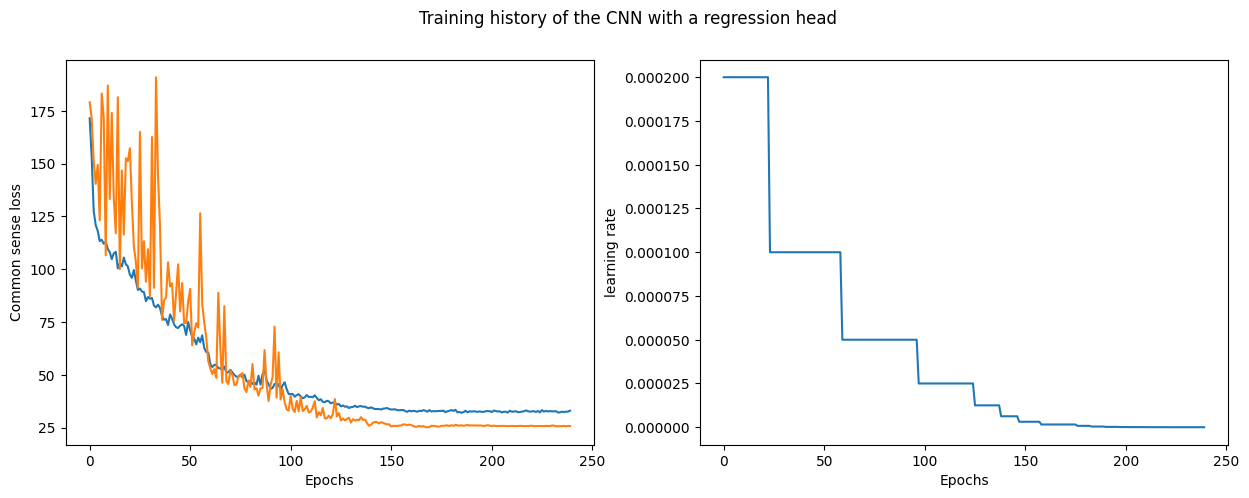

In [26]:
regression_df = pd.read_csv('./task_2/regression_history.csv').iloc[:,1:]
loss_df = regression_df[['loss', 'val_loss']]
lr_df = regression_df['learning_rate']

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(len(loss_df['loss'])), loss_df['loss'], label='train')
ax[0].plot(range(len(loss_df['val_loss'])), loss_df['val_loss'], label='validation')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Common sense loss')
ax[0].legend

ax[1].plot(range(len(lr_df)), lr_df)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('learning rate')

fig.suptitle('Training history of the CNN with a regression head')